# TP 2 : Computer Vision

## Part 3 : motion estimation

In this part of the TP, we are going to look at the following method for estimating motion :

- block matching

First, let us again load some packages and define some helper functions

C:\Users\槐序有陆\AppData\Local\Temp\ipykernel_16260\1478144760.py:7: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_dilation
C:\Users\槐序有陆\AppData\Local\Temp\ipykernel_16260\1478144760.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_color = imageio.imread(file_name)


(448, 624)

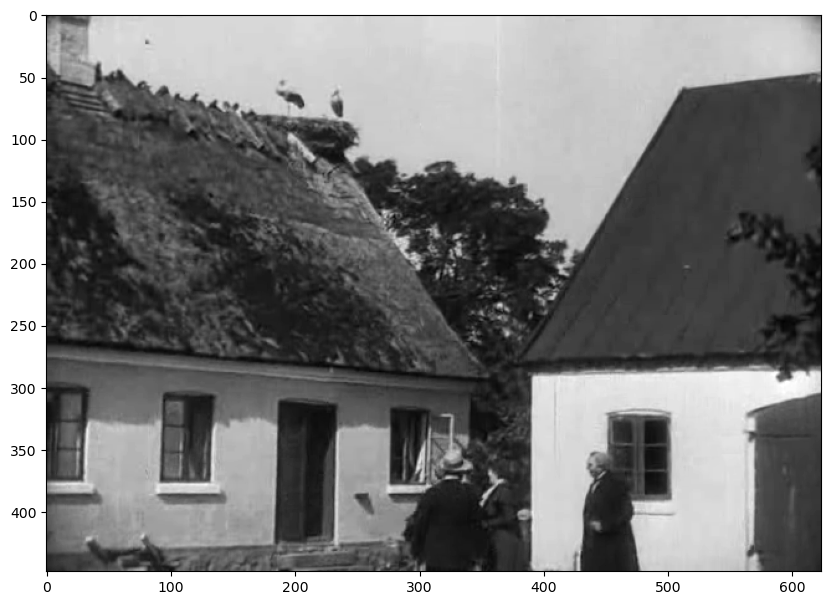

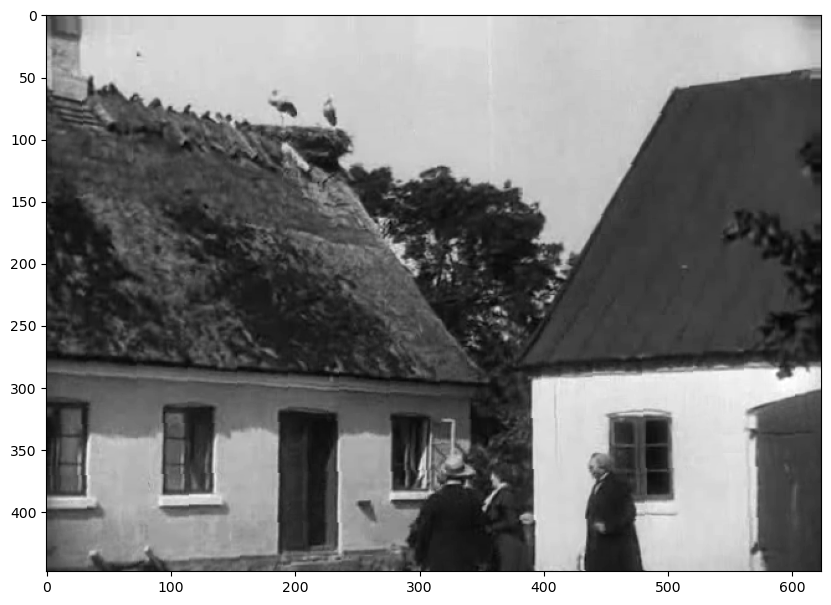

In [31]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np 
import imageio
from skimage import color
from scipy import signal
from scipy.ndimage.morphology import binary_dilation

is_colab = False

def read_image(file_name):
    img_color = imageio.imread(file_name)
    img_gray = color.rgb2gray(img_color)
    return img_gray,img_color
    
def write_image(img_in,file_name_out):
    imageio.imwrite(file_name_out, np.uint8(255.0*img_in))
    
def display_image(img_in):
    plt.figure(figsize=(10, 10))
    if (img_in.ndim == 2):
        plt.imshow(img_in,cmap='gray')
    elif (img_in.ndim == 3):
        # careful, in this case we supppose the pixel values are between 0 and 255
        plt.imshow(np.uint8(img_in))
    else:
        print('Error, unknown number of dimensions in image')
    return

def display_motion(img_1,img_2,key_pts,motion,file_save=''):
    
    motion_x = motion[:,0]
    motion_y = motion[:,1]
    
    img_size = img_1.shape
    
    head_width=2.0
    head_length=3.0

    fig = plt.figure()
    plt.figure(figsize=(10, 10))
    ax = plt.imshow(img_1,cmap='gray')

    print(key_pts.shape[0])
    for i in range(0,key_pts.shape[0]):
        x = key_pts[i,0]
        y = key_pts[i,1]
        plt.arrow(x,y, motion_x[i],motion_y[i] , color='r',
            head_width=head_width, head_length=head_length,)
    plt.gca().set_axis_off()
    fig.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(mpl.ticker.NullLocator())
    plt.gca().yaxis.set_major_locator(mpl.ticker.NullLocator())

    if (file_save != ''):
        plt.savefig(file_save, bbox_inches = 'tight', pad_inches = 0)

file_dir = 'images/'
file_name_1 = 'afgrunden_1'
file_name_2 = 'afgrunden_2'
file_ext = '.png'

if (is_colab == True):
  !wget "https://perso.telecom-paristech.fr/anewson/doc/images/afgrunden_1.png"
  !wget "https://perso.telecom-paristech.fr/anewson/doc/images/afgrunden_2.png"
  img_1,_ = read_image(file_name_1+file_ext)
  img_2,_ = read_image(file_name_2+file_ext)
else:
  img_1,_ = read_image(file_dir+file_name_1+file_ext)
  img_2,_ = read_image(file_dir+file_name_2+file_ext)

display_image(img_1)
display_image(img_2)
img_size = img_1.shape
img_size

__Question 3.1__ What sort of motion do you think is there between img_1 and img_2 ? You may want to flip between one image and another in an external viewer.

__Answer__: There is a tranlation between these two images.

## Block matching

Block matching is a very intuitive algorithm for motion estimation. We choose a patch size, and for each patch $\Psi_p$ in the first frame, we look for the patch $\Psi_q$ which is the most similar, in a certain region around the original position. The motion $(u,v)$ is then defined as $(u,v) = q-p$, such that : 

$
\begin{cases}
q_x = p_x+u\\
q_y = p_y+v
\end{cases}
$

The ''similarity'' between two patches is the sum of squared differences (SSD) :

$d(\Psi_p,\Psi_q) = \sum_{i \in \mathcal{N}} \left( I(p+i) - I(q+i) \right)^2,$

where $\mathcal{N}$ is the patch neighbourhood (a square).

We are going to be implementing block matching in a function called ``block_matching``. However, this can take a lot of time, so we only carry it out on a subset of the pixels, which we will call ``key_pts``. This will be a matrix of size $(N,2)$, where $N$ is the number of keypoints, and where each line has the following format :

- $[x,y]$

Create this function now, with the following parameters :

- block_size = 7 (the patch size)
- search_size = 15 (the maximum distance we search for the same patch in)

You will have to deal with border conditions. There are two ways of doing this :

- not allowing the patch search to go near to the borders (no closer than half the patch size)
- making partial patch comparisons

You can choose either method. The first is slightly easier to implement, but potentially incorrect near the borders. The second is more correct, but you have to make sure to make partial patch comparisons.

Make sure you do __not__ carry out the patch distance with a loop (which would not be very optimal). You can first create the patch neighbourhood with

- ``np.meshgrid``

and then take the SSD of the two patches.


In [29]:
def search_patch(pt, img, patch_size=7):
    half_width = patch_size // 2
    return img[pt[0]-half_width:pt[0]+half_width+1, pt[1]-half_width:pt[1]+half_width+1]

In [34]:
def search_window(pt, img_shape, search_size=15, patch_size=7):
    half_width = patch_size // 2
    half_width_win = search_size // 2
    x_min = max(pt[0] - half_width_win, half_width)
    x_max = min(pt[0] + half_width_win, img_shape[0] - 1 - half_width)
    y_min = max(pt[1] - half_width_win, half_width)
    y_max = min(pt[1] + half_width_win, img_shape[1] - 1 - half_width)
    return np.asarray([(i,j) for i in range(x_min, x_max+1) for j in range(y_min, y_max+1)])

In [35]:
def close_to_border(pt, img_shape, patch_size=7):
    half_width = patch_size // 2
    for i in [0,1]:
        if pt[i] < half_width or pt[i] + half_width >= img_shape[i]:
            return True
    return False

In [40]:
def block_matching(img_1,img_2,key_pts):

    assert (img_1.shape == img_2.shape)
    motion = []
    for pt in key_pts:
        # we don't consider the points near border
        if close_to_border(pt, img_1.shape):
            motion.append(np.asarray([0,0]))
            continue
        patch1 = search_patch(pt, img_1)
        window = search_window(pt, img_1.shape)
        min_dist = np.Inf
        min_pt = (-1,-1)
        for pt2 in window:
            patch2 = search_patch(pt2, img_2)
            dist = np.sum((patch1 - patch2)**2)
            if dist < min_dist:
                min_dist = dist
                min_pt = pt2
        motion.append(pt-min_pt)
    motion = np.asarray(motion) # FILL IN HERE. ``motion'' SHOULD BE A MATRIX OF SIZE [n_pts,2]

    return motion

We now draw some random keypoints.

In [37]:
n_pts = 80
key_pts = np.zeros((n_pts,2)).astype(int)
# a random seed, if you want repeatability
np.random.seed(10)

pixel_list = np.asarray(range(0,img_size[0]*img_size[1]))
np.random.shuffle(pixel_list)
key_pts = np.zeros((n_pts,2)).astype(int)
key_pts[:,1],key_pts[:,0] = np.unravel_index(pixel_list[0:n_pts],img_size)

In [38]:
key_pts[:,0].max()

621

Carry out the block matching and display the result with the ``display_motion`` function.

In [41]:
motion = block_matching(img_1,img_2,key_pts) # FILL IN HERE

80
80


<Figure size 640x480 with 0 Axes>

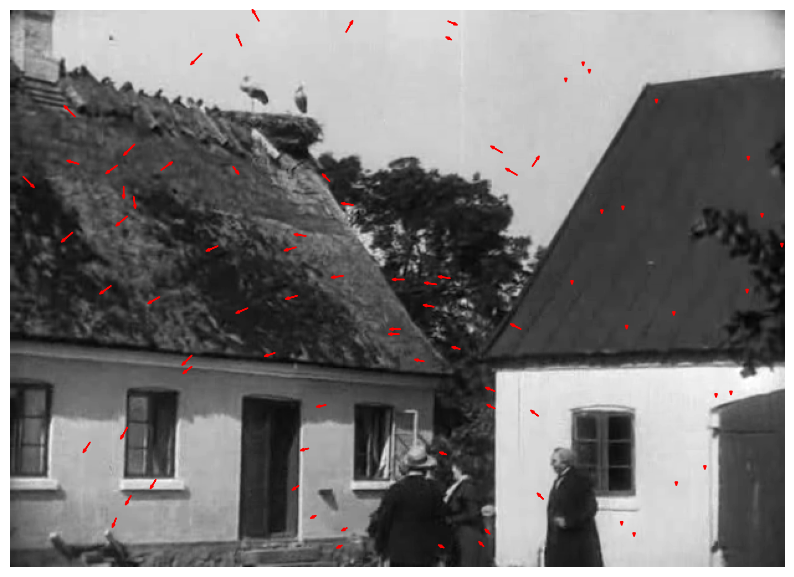

<Figure size 640x480 with 0 Axes>

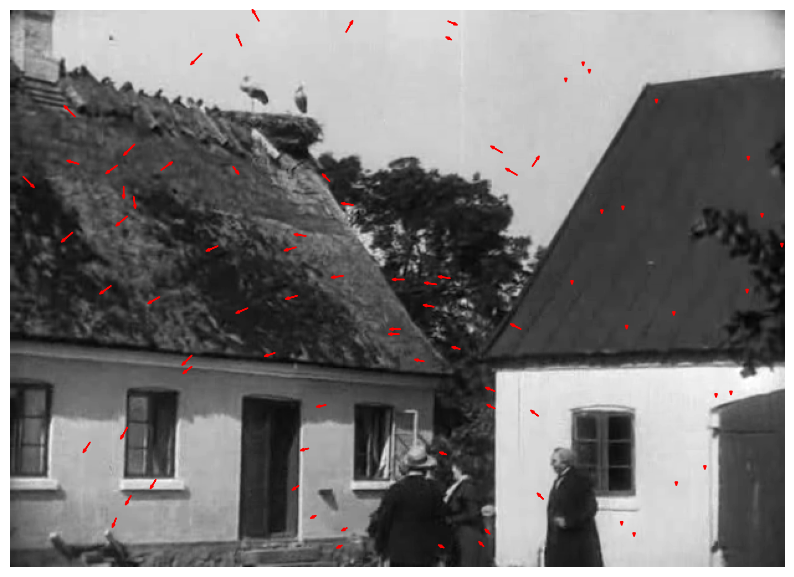

In [42]:
display_motion(img_1,img_2,key_pts,motion)
display_motion(img_1,img_2,key_pts,motion,file_name_1+'_motion_out.png')

__Question 3.2__ Does this look reasonable to you ? In what regions do you think the estimation might fail ? Does this visualisation confirm your hypothesis concerning the type of motion ?

__Answer__ : Non, the motion in different in several regions, which is not logic. In the regions where the grey scale change slowly (for example on the left roof), it is difficult to detect the true motion. Thus, the estimation might fail. In some regions, like right roof and right white wall, our hypothesis about the translation motion can be confirmed.

__Question 3.3__ In this exercise, we used random points. What methods seen in the lesson could you use to choose better points. Explain why such points are better suited for the block matching algorithm.

__Answer__: We can select the points who have bigger gradients. In the neighbourhood of such points, the block matching algorithm may detect the motion direction more easily, to avoid aperture problem.

__Question 3.4__ In this work, we have considered that each pixel/patch has its own, separate, local, motion. This is not the best model for the motion observed in these two images.

What is a better motion model to use here? Why is this model better? Describe an algorithm to calculate such a motion.

__Answer__: We can use `optical flow` model, which regularise the motion field using a variational framework. In this way, the motion in different regions would be similar. 

We consider small displacements and thus we can carry out a Talor development. Using the brightness constancy hypothesis and adding the derivative of gradients in the objective function, we solve then Euler-Lagrange equations to find solutions. In this way, we can get a solution with a small gradient (the optical flow becomes smoother).